In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
import datetime


In [2]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import pandas as pd
from collections import defaultdict

torch.set_default_dtype(torch.float32)

In [3]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [4]:
from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface

In [5]:
from io import BytesIO

In [6]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score

In [7]:
import seaborn as sns

In [8]:
DEVICE="cuda:0"

In [9]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [10]:
TEST_RUN = False

## Load data

In [11]:
# def calculate_mean_and_std():
#     train_data = datasets.FashionMNIST(root='./fashion/data/train', 
#                                        download=True, train=True, 
#                                        transform=transforms.ToTensor())
#     mean = (train_data.data.type(torch.float32) / 255).mean().item()
#     std = (train_data.data.type(torch.float32) / 255).std().item()
#     return mean, std

# mean, std = calculate_mean_and_std()
# mean, std

In [12]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.286,), (0.353,)),    #mean and std of FMNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.FashionMNIST(root='./fashion/data/train', train=True, download=True, transform=mods)
testset = datasets.FashionMNIST(root='./fashion/data/test', train=False, download=True, transform=mods)

In [13]:
X, y = trainset.data.numpy(), trainset.targets.numpy()

In [14]:
def prepare_data(X, y, size=None):
    X = X.reshape(-1, 784)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y, random_state=42)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=100)

In [16]:
X[0].shape

(28, 28)

In [17]:
y_train.shape

torch.Size([100])

In [18]:
unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))

{0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}


In [19]:
y_test.shape

torch.Size([59900])

In [20]:
unique, counts = np.unique(y_test, return_counts=True)

print(dict(zip(unique, counts)))

{0: 5990, 1: 5990, 2: 5990, 3: 5990, 4: 5990, 5: 5990, 6: 5990, 7: 5990, 8: 5990, 9: 5990}


In [21]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    
    results.append({
        "Class": "acc_score",
        "Metric": accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    
    results.append({
        "Class": "balanced_accuracy",
        "Metric": balanced_accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "ROC score",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    results.append({
        "Class": "Loss",
        "Metric": criterion(torch.from_numpy(y_score), y_test).item()*100
    })
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if TEST_RUN:
        iters = 2
    
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1]))
    
    results = []

    for i in range(iters):
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

In [22]:
criterion = torch.nn.CrossEntropyLoss()

## Benchmark

### XGBoost

from xgboost import XGBClassifier

def get_xgboost():
    random_seed = np.random.randint(1024)
    return XGBClassifier(
        verbosity=0,
        random_state=random_seed,
        subsample=0.9,
        eta=0.1,
        use_label_encoder=False)

xgb_dframe = test_model(get_xgboost, 
                        (X, y),
                        100,
                        None, iters=10)

xgb_dframe[xgb_dframe["Class"]=="Total"].reset_index(drop=True)

### Random forest

from sklearn.ensemble import RandomForestClassifier

def get_rf(n_estimator):
    def _inner():
        random_seed = np.random.randint(1024)
        return RandomForestClassifier(
            random_state=random_seed)
    return _inner

rf_dframe = test_model(get_rf(estimators), 
                        (X, y),
                        100,
                        None, iters=10)

rf_dframe[rf_dframe["Class"]=="Total"].reset_index(drop=True).max()

### HypernetworkPCA

def network_pca_fn(epochs=10, masks_no=100, mask_size=100):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, 100), (100, 10)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(16, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=784
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

epochs = 150
mask_size = 50
masks_no = 100
data_size = 100
results = defaultdict(dict)

hyper_pca_results = test_model(network_pca_fn(epochs, masks_no, mask_size),
                (X, y),
                data_size,
                None, 4)
results[mask_size][masks_no] = hyper_pca_results[hyper_pca_results["Class"]=="Total"].reset_index(drop=True).mean()

# exp.log_table("metrics.csv", hyper_pca_results.groupby("Class").mean())

hyper_pca_results[hyper_pca_results["Class"]=="Total"].reset_index(drop=True).max()

### Hypernetwork

In [23]:
def network_fn(epochs=10, masks_no=100, mask_size=100):
    if TEST_RUN:
        epochs = 1
        
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, 100), (100, 10)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(784, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=128)
        return network
    return _inner

In [24]:
results_acc = defaultdict(dict)
results_acc

defaultdict(dict, {})

In [25]:
results_ascore = defaultdict(dict)

In [26]:
results_ba = defaultdict(dict)
results_ba

defaultdict(dict, {})

In [27]:
mask_sizes = [10, 20, 30, 50, 100, 150, 200, 300, 320, 350, 400]
mask_numbers = [3, 5, 10, 20, 50, 80, 100, 200, 300, 350, 400]


masks_no 3
mask_size 10
torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.29it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.29it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:53<00:00,  2.26it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 20
torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.29it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:51<00:00,  2.31it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.30it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 30
torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.30it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.30it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.28it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:51<00:00,  2.31it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 50
torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:53<00:00,  2.26it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.28it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 100
torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.28it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:53<00:00,  2.24it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:51<00:00,  2.32it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.29it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 150
torch.Size([1, 128])


100%|██████████| 120/120 [00:53<00:00,  2.25it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:13<00:00,  1.64it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 200
torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.29it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:51<00:00,  2.31it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 300
torch.Size([1, 128])


100%|██████████| 120/120 [00:53<00:00,  2.25it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.29it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.27it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:53<00:00,  2.26it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 3
mask_size 320
torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.26it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.28it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:52<00:00,  2.28it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [00:53<00:00,  2.23it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 120/120 [01:08<00:00,  1.75it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only v

masks_no 10
mask_size 20
torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.75it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:06<00:00,  1.79it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.76it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.77it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 10
mask_size 30
torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.76it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.77it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.78it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.78it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 10
mask_size 50
torch.Size([1, 128])


100%|██████████| 120/120 [01:09<00:00,  1.74it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:06<00:00,  1.81it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.78it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:06<00:00,  1.81it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 10
mask_size 100
torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.75it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.78it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.75it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.74it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 10
mask_size 150
torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.78it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.75it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.78it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.77it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 10
mask_size 200
torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.77it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:08<00:00,  1.76it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:07<00:00,  1.77it/s]


torch.Size([1, 128])


 23%|██▎       | 28/120 [00:16<00:53,  1.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 120/120 [01:33<00:00,  1.28it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only val

masks_no 20
mask_size 350
torch.Size([1, 128])


100%|██████████| 120/120 [01:35<00:00,  1.26it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:34<00:00,  1.27it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:35<00:00,  1.25it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:34<00:00,  1.27it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 20
mask_size 400
torch.Size([1, 128])


100%|██████████| 120/120 [01:37<00:00,  1.23it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:37<00:00,  1.23it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:36<00:00,  1.24it/s]


torch.Size([1, 128])


100%|██████████| 120/120 [01:37<00:00,  1.24it/s]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 10
torch.Size([1, 128])


100%|██████████| 120/120 [02:34<00:00,  1.29s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:40<00:00,  1.84s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:35<00:00,  1.80s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [02:34<00:00,  1.29s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 20
torch.Size([1, 128])


100%|██████████| 120/120 [02:43<00:00,  1.36s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [02:36<00:00,  1.30s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [02:35<00:00,  1.30s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [02:35<00:00,  1.29s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 30
torch.Size([1, 128])


100%|██████████| 120/120 [02:35<00:00,  1.29s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [02:56<00:00,  1.47s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:01<00:00,  1.51s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [02:36<00:00,  1.30s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 50
torch.Size([1, 128])


100%|██████████| 120/120 [02:33<00:00,  1.28s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [02:55<00:00,  1.46s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:07<00:00,  1.56s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:06<00:00,  1.55s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 100
torch.Size([1, 128])


100%|██████████| 120/120 [03:07<00:00,  1.56s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:20<00:00,  1.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:18<00:00,  1.65s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:19<00:00,  1.67s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 150
torch.Size([1, 128])


100%|██████████| 120/120 [03:03<00:00,  1.53s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:02<00:00,  1.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:03<00:00,  1.53s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:02<00:00,  1.52s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 200
torch.Size([1, 128])


100%|██████████| 120/120 [03:01<00:00,  1.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:16<00:00,  1.64s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:18<00:00,  1.65s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:18<00:00,  1.66s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 300
torch.Size([1, 128])


100%|██████████| 120/120 [03:20<00:00,  1.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:13<00:00,  1.61s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:05<00:00,  1.54s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:05<00:00,  1.55s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 320
torch.Size([1, 128])


100%|██████████| 120/120 [03:02<00:00,  1.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:03<00:00,  1.53s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:02<00:00,  1.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:03<00:00,  1.53s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 50
mask_size 350
torch.Size([1, 128])


100%|██████████| 120/120 [03:05<00:00,  1.55s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:06<00:00,  1.56s/it]


torch.Size([1, 128])


 60%|██████    | 72/120 [01:56<01:18,  1.64s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results

masks_no 80
mask_size 300
torch.Size([1, 128])


100%|██████████| 120/120 [03:49<00:00,  1.91s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:51<00:00,  1.93s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:01<00:00,  2.01s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [03:58<00:00,  1.99s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 80
mask_size 320
torch.Size([1, 128])


100%|██████████| 120/120 [03:58<00:00,  1.98s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:02<00:00,  2.02s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:05<00:00,  2.05s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:04<00:00,  2.04s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 80
mask_size 350
torch.Size([1, 128])


100%|██████████| 120/120 [04:07<00:00,  2.06s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:04<00:00,  2.04s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:02<00:00,  2.02s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:21<00:00,  2.18s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 80
mask_size 400
torch.Size([1, 128])


100%|██████████| 120/120 [04:22<00:00,  2.19s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:24<00:00,  2.21s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:24<00:00,  2.20s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [04:24<00:00,  2.20s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 100
mask_size 10
torch.Size([1, 128])


100%|██████████| 120/120 [05:03<00:00,  2.53s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:03<00:00,  2.53s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:07<00:00,  2.56s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:13<00:00,  2.61s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 100
mask_size 20
torch.Size([1, 128])


100%|██████████| 120/120 [05:06<00:00,  2.56s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:00<00:00,  2.51s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:26<00:00,  2.72s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:22<00:00,  2.69s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 100
mask_size 30
torch.Size([1, 128])


100%|██████████| 120/120 [05:26<00:00,  2.72s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:26<00:00,  2.72s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:30<00:00,  2.76s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [05:45<00:00,  2.88s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 100
mask_size 50
torch.Size([1, 128])


100%|██████████| 120/120 [05:47<00:00,  2.89s/it]


torch.Size([1, 128])


 13%|█▎        | 16/120 [00:46<05:06,  2.94s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 128])


100%|██████████| 120/120 [09:18<00:00,  4.65s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:09<00:00,  4.58s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 200
mask_size 100
torch.Size([1, 128])


100%|██████████| 120/120 [09:10<00:00,  4.59s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:13<00:00,  4.61s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:08<00:00,  4.57s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:13<00:00,  4.61s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 200
mask_size 150
torch.Size([1, 128])


100%|██████████| 120/120 [09:20<00:00,  4.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:22<00:00,  4.69s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:18<00:00,  4.66s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:21<00:00,  4.68s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 200
mask_size 200
torch.Size([1, 128])


100%|██████████| 120/120 [09:20<00:00,  4.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:21<00:00,  4.68s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:26<00:00,  4.72s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:23<00:00,  4.69s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 200
mask_size 300
torch.Size([1, 128])


100%|██████████| 120/120 [09:26<00:00,  4.72s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:37<00:00,  4.81s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:35<00:00,  4.80s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:42<00:00,  4.86s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 200
mask_size 320
torch.Size([1, 128])


100%|██████████| 120/120 [09:19<00:00,  4.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:36<00:00,  4.80s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:46<00:00,  4.89s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [09:49<00:00,  4.91s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 200
mask_size 350
torch.Size([1, 128])


100%|██████████| 120/120 [09:55<00:00,  4.96s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [10:27<00:00,  5.23s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [10:47<00:00,  5.39s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [10:45<00:00,  5.38s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 200
mask_size 400
torch.Size([1, 128])


100%|██████████| 120/120 [11:01<00:00,  5.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [11:00<00:00,  5.50s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [11:04<00:00,  5.54s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [11:45<00:00,  5.88s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 10
torch.Size([1, 128])


100%|██████████| 120/120 [16:48<00:00,  8.40s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:26<00:00,  8.22s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:31<00:00,  8.27s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:22<00:00,  8.19s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 20
torch.Size([1, 128])


100%|██████████| 120/120 [13:30<00:00,  6.75s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:37<00:00,  6.82s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:33<00:00,  6.78s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:30<00:00,  6.76s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 30
torch.Size([1, 128])


100%|██████████| 120/120 [13:25<00:00,  6.71s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:14<00:00,  6.62s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:02<00:00,  6.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:01<00:00,  6.51s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 50
torch.Size([1, 128])


100%|██████████| 120/120 [13:03<00:00,  6.53s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:07<00:00,  6.56s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:05<00:00,  6.54s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:13<00:00,  6.61s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 100
torch.Size([1, 128])


100%|██████████| 120/120 [13:23<00:00,  6.70s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:20<00:00,  6.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:25<00:00,  6.71s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:20<00:00,  6.67s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 150
torch.Size([1, 128])


100%|██████████| 120/120 [13:47<00:00,  6.90s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:43<00:00,  6.86s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:47<00:00,  6.90s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:49<00:00,  6.91s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 200
torch.Size([1, 128])


100%|██████████| 120/120 [13:58<00:00,  6.99s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:15<00:00,  7.13s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:03<00:00,  7.03s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:03<00:00,  7.03s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 300
torch.Size([1, 128])


100%|██████████| 120/120 [14:47<00:00,  7.40s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:48<00:00,  7.41s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:46<00:00,  7.38s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:49<00:00,  7.41s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 320
torch.Size([1, 128])


100%|██████████| 120/120 [14:39<00:00,  7.33s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:38<00:00,  7.32s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:41<00:00,  7.35s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:29<00:00,  7.24s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 350
torch.Size([1, 128])


100%|██████████| 120/120 [14:13<00:00,  7.12s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:12<00:00,  7.10s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:10<00:00,  7.09s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:05<00:00,  7.55s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 300
mask_size 400
torch.Size([1, 128])


100%|██████████| 120/120 [16:19<00:00,  8.16s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:19<00:00,  8.16s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:21<00:00,  8.18s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:18<00:00,  8.15s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 10
torch.Size([1, 128])


100%|██████████| 120/120 [16:32<00:00,  8.27s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:36<00:00,  8.31s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:31<00:00,  8.26s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [18:39<00:00,  9.33s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 20
torch.Size([1, 128])


100%|██████████| 120/120 [18:40<00:00,  9.34s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [18:40<00:00,  9.34s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [18:36<00:00,  9.31s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [18:33<00:00,  9.28s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 30
torch.Size([1, 128])


100%|██████████| 120/120 [18:37<00:00,  9.31s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:33<00:00,  7.78s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:07<00:00,  6.57s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [20:48<00:00, 10.40s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 50
torch.Size([1, 128])


100%|██████████| 120/120 [21:28<00:00, 10.74s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:29<00:00, 10.75s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:26<00:00, 10.72s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:26<00:00, 10.72s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 100
torch.Size([1, 128])


100%|██████████| 120/120 [21:53<00:00, 10.95s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:53<00:00, 10.95s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:25<00:00, 10.71s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:26<00:00, 10.72s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 150
torch.Size([1, 128])


100%|██████████| 120/120 [21:26<00:00, 10.72s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:20<00:00, 10.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:24<00:00, 10.70s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [21:24<00:00, 10.71s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 200
torch.Size([1, 128])


100%|██████████| 120/120 [16:11<00:00,  8.09s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:30<00:00,  6.76s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:24<00:00,  6.70s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:27<00:00,  6.73s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 300
torch.Size([1, 128])


100%|██████████| 120/120 [14:08<00:00,  7.07s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:09<00:00,  7.08s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:02<00:00,  7.02s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [13:59<00:00,  7.00s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 320
torch.Size([1, 128])


100%|██████████| 120/120 [14:22<00:00,  7.18s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:19<00:00,  7.17s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:24<00:00,  7.21s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:25<00:00,  7.21s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 350
torch.Size([1, 128])


100%|██████████| 120/120 [14:33<00:00,  7.28s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:32<00:00,  7.27s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:34<00:00,  7.29s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:34<00:00,  7.29s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 350
mask_size 400
torch.Size([1, 128])


100%|██████████| 120/120 [15:14<00:00,  7.62s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:14<00:00,  7.62s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:20<00:00,  7.67s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:17<00:00,  7.65s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 10
torch.Size([1, 128])


100%|██████████| 120/120 [15:11<00:00,  7.60s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:08<00:00,  7.57s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:00<00:00,  7.51s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:01<00:00,  7.51s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 20
torch.Size([1, 128])


100%|██████████| 120/120 [15:13<00:00,  7.61s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:09<00:00,  7.58s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:06<00:00,  7.56s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:57<00:00,  7.48s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 30
torch.Size([1, 128])


100%|██████████| 120/120 [15:19<00:00,  7.66s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:08<00:00,  7.57s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:06<00:00,  7.56s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:00<00:00,  7.50s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 50
torch.Size([1, 128])


100%|██████████| 120/120 [15:06<00:00,  7.55s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [14:53<00:00,  7.44s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:02<00:00,  7.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:11<00:00,  7.60s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 100
torch.Size([1, 128])


100%|██████████| 120/120 [15:08<00:00,  7.57s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:11<00:00,  7.59s/it]


torch.Size([1, 128])


 13%|█▎        | 16/120 [02:02<12:36,  7.28s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 120/120 [15:13<00:00,  7.61s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:11<00:00,  7.59s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:11<00:00,  7.60s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 300
torch.Size([1, 128])


100%|██████████| 120/120 [15:51<00:00,  7.93s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:51<00:00,  7.93s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:07<00:00,  8.07s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:55<00:00,  7.96s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 320
torch.Size([1, 128])


100%|██████████| 120/120 [16:21<00:00,  8.18s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:23<00:00,  8.19s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:13<00:00,  8.11s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [15:58<00:00,  7.99s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 350
torch.Size([1, 128])


100%|██████████| 120/120 [16:17<00:00,  8.15s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:19<00:00,  8.16s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:15<00:00,  8.13s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [16:12<00:00,  8.11s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

masks_no 400
mask_size 400
torch.Size([1, 128])


100%|██████████| 120/120 [17:10<00:00,  8.59s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [17:06<00:00,  8.55s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [17:02<00:00,  8.52s/it]


torch.Size([1, 128])


100%|██████████| 120/120 [17:08<00:00,  8.57s/it]
/tmp/ipykernel_2322426/3733492062.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()
/tmp/ipykernel_2322426/3733492062.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid 

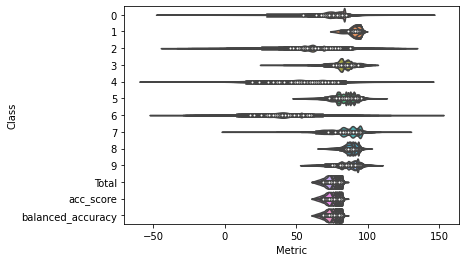

In [28]:
epochs = 120
# mask_size = 80
# masks_no = 100
data_size = 1000
# results = defaultdict(dict)

for masks_no in mask_numbers:
    for mask_size in mask_sizes:

        print('masks_no', masks_no)
        print('mask_size', mask_size)
        
        nn_results = test_model(network_fn(epochs, masks_no, mask_size),
                        (X, y),
                        data_size,
                        None, 4)
        
        results_acc[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()
        results_ascore[mask_size][masks_no] = nn_results[nn_results["Class"]=="acc_score"].reset_index(drop=True).mean()

        
        results_ba[mask_size][masks_no] = nn_results[nn_results["Class"]=="balanced_accuracy"].reset_index(drop=True).mean()
        


In [29]:
nn_results[nn_results["Class"]=="balanced_accuracy"].reset_index(drop=True).mean()

/tmp/ipykernel_2322426/4037359792.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nn_results[nn_results["Class"]=="balanced_accuracy"].reset_index(drop=True).mean()


Metric    72.291102
dtype: float64

In [30]:
nn_results

,Class,Metric
0,0,59.355932
1,1,94.881356
2,2,66.135593
3,3,85.627119
4,4,47.576271
5,5,69.084746
6,6,46.864407
7,7,92.745763
8,8,88.067797
9,9,70.711864


In [31]:
results_acc

defaultdict(dict,
            {10: {3: Metric    68.490254
              dtype: float64,
              5: Metric    72.991949
              dtype: float64,
              10: Metric    76.014407
              dtype: float64,
              20: Metric    77.698729
              dtype: float64,
              50: Metric    76.75339
              dtype: float64,
              80: Metric    75.139831
              dtype: float64,
              100: Metric    77.061441
              dtype: float64,
              200: Metric    75.644915
              dtype: float64,
              300: Metric    75.568644
              dtype: float64,
              350: Metric    73.605932
              dtype: float64,
              400: Metric    74.867373
              dtype: float64},
             20: {3: Metric    74.30339
              dtype: float64,
              5: Metric    75.451271
              dtype: float64,
              10: Metric    79.800424
              dtype: float64,
              20: Metr

In [32]:
results_ba

defaultdict(dict,
            {10: {3: Metric    68.490254
              dtype: float64,
              5: Metric    72.991949
              dtype: float64,
              10: Metric    76.014407
              dtype: float64,
              20: Metric    77.698729
              dtype: float64,
              50: Metric    76.75339
              dtype: float64,
              80: Metric    75.139831
              dtype: float64,
              100: Metric    77.061441
              dtype: float64,
              200: Metric    75.644915
              dtype: float64,
              300: Metric    75.568644
              dtype: float64,
              350: Metric    73.605932
              dtype: float64,
              400: Metric    74.867373
              dtype: float64},
             20: {3: Metric    74.30339
              dtype: float64,
              5: Metric    75.451271
              dtype: float64,
              10: Metric    79.800424
              dtype: float64,
              20: Metr

Acc

In [33]:
res_acc_df = pd.DataFrame(results_acc)
res_acc_df = res_acc_df.fillna(res_acc_df.iloc[0, 0])
res_acc_df = res_acc_df.apply(lambda x: [i[0] if not isinstance(i, float) else i for i in x])
res_acc_df = res_acc_df.loc[:, sorted(res_acc_df.columns)]

In [34]:
# res_acc_df = pd.read_csv("FMNIST_heatmap_acc_100_15.01.2023_15:09:51_.csv", index_col=0)
# res_acc_df

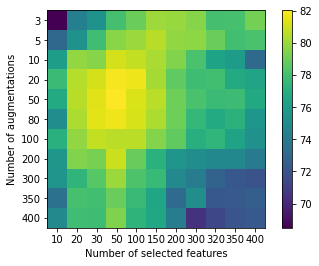

In [46]:
plt.imshow(res_acc_df)
plt.yticks(np.arange(len(res_acc_df)), res_acc_df.index);
plt.xticks(np.arange(len(res_acc_df.columns)), res_acc_df.columns);

plt.xlabel("Number of selected features")
plt.ylabel("Number of augmentations")
plt.colorbar()
# plt.title("Accuracy on F-MNIST with 1000 samples")

In [36]:
date_time = str(datetime.datetime.now().strftime("%d.%m.%Y_%H:%M:%S"))

In [37]:
res_acc_df.to_csv(f"FMNIST_heatmap_acc_{data_size}_{date_time}_.csv")

In [38]:
with open(f"FMNIST_heatmap_acc_{data_size}_{date_time}_.info", "a") as f:
    f.write("mask_sizes: " + str(mask_sizes) + '\n')
    f.write("mask_numbers: " + str(mask_numbers) + '\n')

BA

In [39]:
res_ba_df = pd.DataFrame(results_ba)
res_ba_df = res_ba_df.fillna(res_ba_df.iloc[0, 0])
res_ba_df = res_ba_df.apply(lambda x: [i[0] if not isinstance(i, float) else i for i in x])
res_ba_df = res_ba_df.loc[:, sorted(res_ba_df.columns)]

Text(0.5, 1.0, 'Balanced accuracy vs parameters')

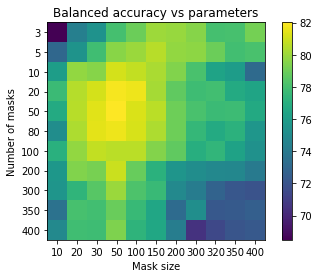

In [40]:
plt.imshow(res_ba_df)
plt.yticks(np.arange(len(res_ba_df)), res_ba_df.index);
plt.xticks(np.arange(len(res_ba_df.columns)), res_ba_df.columns);
plt.xlabel("Mask size")
plt.ylabel("Number of masks")
plt.colorbar()
plt.title("Balanced accuracy vs parameters")

In [41]:
date_time = str(datetime.datetime.now().strftime("%d.%m.%Y_%H:%M:%S"))

In [42]:
res_ba_df.to_csv(f"FMNIST_heatmap_ba_{data_size}_{date_time}_.csv")

In [43]:
with open(f"FMNIST_heatmap_ba_{data_size}_{date_time}_.info", "a") as f:
    f.write("mask_sizes: " + str(mask_sizes) + '\n')
    f.write("mask_numbers: " + str(mask_numbers) + '\n')

Text(0.5, 1.0, 'Accuracy vs parameters')

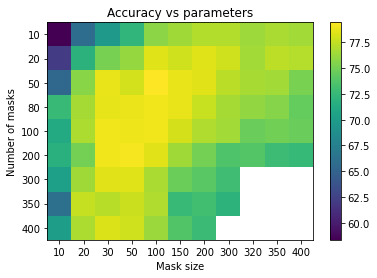

In [87]:
res_df = pd.DataFrame(results)
res_df = res_df.fillna(res_df.iloc[0, 0])
res_df = res_df.apply(lambda x: [i[0] if not isinstance(i, float) else i for i in x])
res_df = res_df.loc[:, sorted(res_df.columns)]
plt.imshow(res_df)
plt.yticks(np.arange(len(res_df)), res_df.index);
plt.xticks(np.arange(len(res_df.columns)), res_df.columns);
plt.xlabel("Mask size")
plt.ylabel("Number of masks")
plt.colorbar()
plt.title("Accuracy vs parameters")

In [44]:
res_df

NameError: name 'res_df' is not defined

### Neural network

In [67]:
def network_fn():
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(1-700/784),
                        torch.nn.Linear(784, 100),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.5),
                        torch.nn.Linear(100, 10)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=150, batch_size=32)
        return network
    return _inner

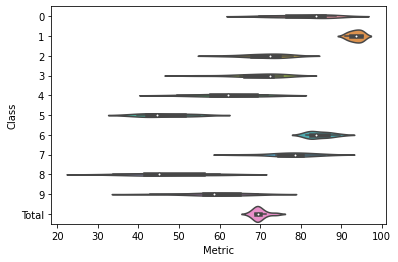

In [68]:
data_size = 100

nn_results = test_model(network_fn(),
                (X, y),
                data_size,
                None, 10)

In [72]:
nn_results[nn_results["Class"]=="Total"].reset_index(drop=True)

,Class,Metric
0,Total,69.295492
1,Total,71.482471
2,Total,69.442404
3,Total,67.570952
4,Total,73.928214
5,Total,69.030050
6,Total,70.273790
7,Total,69.377295
8,Total,68.782972
9,Total,69.527546


### TabNet

In [39]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [44]:
def tabnet_fn():
    clf = TabNetClassifier(verbose=1,n_d=64, n_a=64, n_steps=5,
        gamma=1.5, n_independent=2, n_shared=2,
        cat_emb_dim=1,
        lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2))
    return clf

tabnet_results = test_model(tabnet_fn,
                    (X, y),
                    1024, None, 1, as_numpy=True)

epoch 0  | loss: 4.49442 |  0:00:00s
epoch 1  | loss: 4.10065 |  0:00:00s
epoch 2  | loss: 3.69994 |  0:00:00s
epoch 3  | loss: 3.47651 |  0:00:00s
epoch 4  | loss: 3.53598 |  0:00:00s
epoch 5  | loss: 3.38709 |  0:00:01s
epoch 6  | loss: 3.26813 |  0:00:01s
epoch 7  | loss: 3.2686  |  0:00:01s
epoch 8  | loss: 3.1316  |  0:00:01s
epoch 9  | loss: 3.13288 |  0:00:01s
epoch 10 | loss: 2.90717 |  0:00:01s
epoch 11 | loss: 2.95466 |  0:00:01s
epoch 12 | loss: 2.85828 |  0:00:02s
epoch 13 | loss: 2.76352 |  0:00:02s
epoch 14 | loss: 2.74836 |  0:00:02s
epoch 15 | loss: 2.78355 |  0:00:02s
epoch 16 | loss: 2.78048 |  0:00:02s
epoch 17 | loss: 2.60539 |  0:00:02s
epoch 18 | loss: 2.60996 |  0:00:03s
epoch 19 | loss: 2.57146 |  0:00:03s
epoch 20 | loss: 2.58619 |  0:00:03s
epoch 21 | loss: 2.50692 |  0:00:03s
epoch 22 | loss: 2.51857 |  0:00:03s
epoch 23 | loss: 2.4401  |  0:00:03s
epoch 24 | loss: 2.3768  |  0:00:03s
epoch 25 | loss: 2.36941 |  0:00:04s
epoch 26 | loss: 2.29808 |  0:00:04s
e

In [34]:
tabnet_results[tabnet_results["Class"]=="Total"].reset_index(drop=True)

,Class,Metric
0,Total,61.61659


### NODE

In [14]:
from qhoptim.pyt import QHAdam
import node

In [15]:
X_init = X.reshape(-1, 784)

In [37]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_init.shape[1], layer_dims, num_layers=2, tree_dim=11, depth=6, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x[..., :10].mean(dim=-2))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_init[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=500, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

In [ ]:
exp = Experiment(os.environ.get("COMET_KEY"), "mnist-benchmark-hypernet")
exp.add_tag("node")

node_results = test_model(node_fn(512),
                            (X, y),
                            100,
                            None, 10
                         )
plt.title(layers)
plt.show()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/wwydmanski/mnist-benchmark-hypernet/6d8d95615641402b98577a488e29c52c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [200] : (0.3375752866268158, 2.302137851715088)
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (42.67 KB)
COMET INFO:     installed packages           : 1
COMET INFO:     model graph                  : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COM

In [50]:
node_results[node_results["Class"]=="Total"].reset_index(drop=True)

,Class,Metric
0,Total,75.242070
1,Total,74.041736
2,Total,75.803005
3,Total,75.988314
4,Total,74.517529
5,Total,75.666110
6,Total,76.679466
7,Total,74.490818
8,Total,75.302170
9,Total,76.133556
